<a href="https://colab.research.google.com/github/michelleaeh/Dissertation/blob/master/Horizontal2MyoASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


**The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.**

**Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.**

**The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL**

**If you use this dataset please cite the following papers:**

**@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}**

**@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}**

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns


**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import scipy as sp
import warnings

from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Import zip containing all files
file_name = "/content/2MyoASL.zip"

# Extract all files from zip
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [2]:
# Generate matrices for all combinations of sensors (E=3, A=5, G=7, O=11)
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155]
comb=['e', 'a', 'g', 'o', 'ea', 'eg', 'eo', 'ag', 'ao', 'go', 'eag', 'eao', 'ego', 'ago', 'eago']
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
    'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']

# Initialization of counters
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
colnames=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 
          'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
headers=np.empty(1701, dtype=object)
features=np.zeros(15)
target=np.zeros(15)
matrix=np.zeros(1)

fn=np.arange(1701)
wordnum=-1
counter=-1
num=0
n=0

In [3]:
# Combine all files
for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)

      trial.reset_index(drop=True)
      
      # Assign word number to one row
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
print(matrix)

     Word  EMG0L  EMG0L  EMG0L  EMG0L  ...    OYR    OYR    OYR    OYR    OYR
0     0.0    0.0    0.0   -3.0   -1.0  ...   83.0   83.0   83.0   83.0   83.0
1     0.0    0.0    0.0    4.0   -2.0  ...   83.0   83.0   83.0   83.0   83.0
2     0.0    0.0    0.0   -8.0   -1.0  ...   84.0   84.0   84.0   84.0   84.0
3     0.0    0.0    0.0   -1.0  -19.0  ...   83.0   83.0   83.0   83.0   83.0
4     0.0    0.0    0.0    1.0  -16.0  ...   93.0   91.0   91.0   91.0   91.0
..    ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
844  35.0    0.0    0.0   -2.0    0.0  ...  106.0  104.0  100.0   98.0   95.0
845  35.0    0.0    0.0    2.0   -8.0  ...  176.0  176.0  177.0  177.0  177.0
846  35.0    0.0    0.0   -8.0   26.0  ...  177.0  176.0  175.0  175.0  176.0
847  35.0    0.0    0.0   -1.0   21.0  ...  178.0  178.0  179.0  179.0  179.0
848  35.0    0.0    0.0    8.0  -19.0  ...  179.0  179.0  179.0  179.0    0.0

[849 rows x 1701 columns]


In [4]:
attempt=matrix
attempt.to_csv(path_or_buf='/content/attempt.csv')

In [5]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  m=matrix
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  products[n]=m
  exec(comb[n]+"=products[n]")
  n+=1
  
  # Normalize and Standardize each of the 15 matrices
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word'].values   # Features
 
  ## Normalize features so that each column is between 0 and 1
  norm_matrix=(m-m.min())/(m.max()-m.min())
  exec("norm_matrix_"+comb[n-1]+"=pd.DataFrame(norm_matrix)")
  exec("norm_matrix_"+comb[n-1]+"=norm_matrix_"+comb[n-1]+".dropna(axis=1)")

 # Standardize features with mean=0 and deviation=1
  standardized_matrix=StandardScaler().fit_transform(x)
  exec("standardized_matrix_"+comb[n-1]+"=pd.DataFrame(standardized_matrix)")
"""
  # Save data frames as csv files
  #matrix.to_csv(path_or_buf='/content/matrix_'+comb[n-1]+'.csv')
  exec("norm_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normmatrix_'+comb[n-1]+'.csv')")
#  exec("normalized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normalizedmatrix_'+comb[n-1]+'.csv')")
  exec("standardized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/standardizedmatrix_'+comb[n-1]+'.csv')")
"""

'\n  # Save data frames as csv files\n  #matrix.to_csv(path_or_buf=\'/content/matrix_\'+comb[n-1]+\'.csv\')\n  exec("norm_matrix_"+comb[n-1]+".to_csv(path_or_buf=\'/content/normmatrix_\'+comb[n-1]+\'.csv\')")\n#  exec("normalized_matrix_"+comb[n-1]+".to_csv(path_or_buf=\'/content/normalizedmatrix_\'+comb[n-1]+\'.csv\')")\n  exec("standardized_matrix_"+comb[n-1]+".to_csv(path_or_buf=\'/content/standardizedmatrix_\'+comb[n-1]+\'.csv\')")\n'

In [6]:
# Replace wordnum with word
for r in range(849):
  wn=int(35*norm_matrix_eago.iloc[r,0])
  norm_matrix_eago.iloc[r,0]=words[wn]
nmatrix=norm_matrix_eago
print(nmatrix)
nmatrix.to_csv(path_or_buf='/content/nmatrix.csv')

           Word     EMG0L     EMG0L  ...       OYR       OYR       OYR
0    allmorning  0.321429  0.388889  ...  0.463687  0.463687  0.463687
1    allmorning  0.321429  0.432099  ...  0.463687  0.463687  0.463687
2    allmorning  0.321429  0.358025  ...  0.469274  0.469274  0.469274
3    allmorning  0.321429  0.401235  ...  0.463687  0.463687  0.463687
4    allmorning  0.321429  0.413580  ...  0.508380  0.508380  0.508380
..          ...       ...       ...  ...       ...       ...       ...
844        wash  0.321429  0.395062  ...  0.558659  0.547486  0.530726
845        wash  0.321429  0.419753  ...  0.988827  0.988827  0.988827
846        wash  0.321429  0.358025  ...  0.977654  0.977654  0.983240
847        wash  0.321429  0.401235  ...  1.000000  1.000000  1.000000
848        wash  0.321429  0.456790  ...  1.000000  1.000000  0.000000

[849 rows x 1693 columns]


In [7]:
# Butterworth
#high = 20/(1000/2)
#low = 450/(1000/2)
high = 1/(50/2)
low = 23/(50/2)

b, a = sp.signal.butter(4, [high,low], btype='bandpass')

for r in emg:
  norm_matrix_eago[[r]]
  # process EMG signal: filter EMG
  emg_filtered = sp.signal.lfilter(b, a, norm_matrix_eago[[r]])
  norm_matrix_eago[[r]]=emg_filtered

In [8]:
buttermatrix=norm_matrix_eago

**Combinations of steps for classification**

score 0.041176470588235294
pred label [22. 22. 22. 22. 22. 22. 13. 22. 22. 22. 13. 22. 13. 13. 22. 22. 22. 22.
 22. 13. 22. 22. 13. 22. 22. 22. 22. 22. 22. 13. 22. 13. 22. 22. 22. 22.
 22. 22. 22. 22. 13. 13. 22. 22. 22. 13. 13. 22. 22. 13. 22. 22. 22. 22.
 13. 22. 22. 13. 22. 22. 22. 22. 22. 22. 13. 22. 22. 22. 22. 13. 22. 22.
 22. 22. 22. 22. 13. 22. 13. 13. 22. 22. 22. 22. 13. 13. 22. 22. 13. 22.
 22. 13. 22. 22. 13. 22. 22. 22. 22. 13. 22. 22. 22. 22. 22. 22. 13. 13.
 22. 13. 13. 22. 22. 22. 22. 13. 22. 22. 22. 22. 13. 22. 13. 13. 22. 22.
 13. 22. 13. 22. 22. 13. 22. 22. 13. 22. 13. 22. 22. 22. 13. 22. 22. 13.
 22. 22. 13. 22. 13. 13. 13. 13. 13. 13. 22. 13. 22. 22. 22. 13. 22. 22.
 22. 22. 13. 13. 22. 22. 13. 22. 13. 22. 22. 13. 22. 22. 13. 22. 22. 13.
 22. 13. 13. 22. 13. 22. 22. 22. 22. 22. 22. 22. 13. 22. 22. 13. 22. 22.
 22. 22. 13. 22. 22. 22. 22. 22. 22. 13. 13. 13. 13. 22. 22. 22. 22. 22.
 22. 22. 13. 22. 22. 22. 22. 22. 22. 22. 22. 22. 13. 22. 22. 22. 22. 22.
 22. 22. 22. 

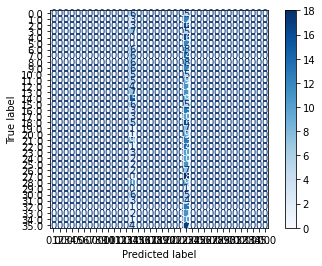

<Figure size 3600x3600 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Directly to SVM
x = attempt.iloc[:, attempt.columns!='Word'].values   # Features
y = attempt.loc[:,'Word'].values     # Target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#print(classification_report(y_test, y_pred, target_names=words))
directresults=classification_report(y_test, y_pred, target_names=words)

score 0.10392156862745099
pred label ['blue' 'large' 'hot' 'large' 'dollar' 'blue' 'dollar' 'blue' 'blue'
 'dollar' 'large' 'blue' 'large' 'dollar' 'shirt' 'hot' 'dollar' 'blue'
 'large' 'dollar' 'dollar' 'hot' 'hot' 'dollar' 'hot' 'blue' 'bird' 'hot'
 'dollar' 'blue' 'blue' 'blue' 'blue' 'hot' 'shirt' 'blue' 'dollar' 'blue'
 'hot' 'hot' 'large' 'large' 'large' 'large' 'blue' 'blue' 'hot' 'blue'
 'hot' 'blue' 'blue' 'dollar' 'hot' 'large' 'dollar' 'blue' 'dollar' 'hot'
 'blue' 'hot' 'large' 'blue' 'dollar' 'dollar' 'blue' 'blue' 'hot' 'blue'
 'hot' 'dollar' 'blue' 'blue' 'blue' 'dollar' 'large' 'blue' 'hot' 'hot'
 'hot' 'large' 'blue' 'hot' 'blue' 'dollar' 'blue' 'hot' 'hot' 'large'
 'blue' 'shirt' 'blue' 'blue' 'hot' 'hot' 'dollar' 'large' 'hot' 'blue'
 'dollar' 'hot' 'blue' 'hot' 'dollar' 'blue' 'shirt' 'hot' 'hot' 'large'
 'hot' 'large' 'dollar' 'hot' 'hot' 'large' 'hot' 'hot' 'blue' 'blue'
 'hot' 'hot' 'large' 'shirt' 'dollar' 'large' 'large' 'blue' 'blue' 'blue'
 'hot' 'blue' 'lar

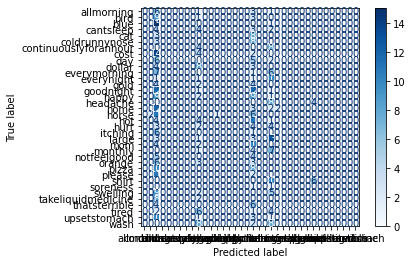

<Figure size 3600x3600 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Normalized to SVM
x = nmatrix.iloc[:, nmatrix.columns!='Word'].values   # Features
y = nmatrix.loc[:,'Word'].values     # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#print(classification_report(y_test, y_pred, target_names=words))
normresults=classification_report(y_test, y_pred, target_names=words)

score 0.07647058823529412
pred label ['cat' 'cat' 'goodnight' 'goodnight' 'goodnight' 'cat' 'goodnight'
 'goodnight' 'goodnight' 'goodnight' 'cat' 'goodnight' 'goodnight'
 'goodnight' 'cat' 'goodnight' 'goodnight' 'everymorning' 'cat'
 'goodnight' 'goodnight' 'cat' 'cat' 'goodnight' 'goodnight' 'goodnight'
 'happy' 'goodnight' 'goodnight' 'goodnight' 'goodnight' 'cat' 'cat' 'cat'
 'shirt' 'goodnight' 'goodnight' 'cat' 'goodnight' 'goodnight' 'shirt'
 'goodnight' 'goodnight' 'goodnight' 'goodnight' 'cat' 'shirt' 'goodnight'
 'cat' 'cat' 'cat' 'goodnight' 'goodnight' 'shirt' 'cat' 'cat' 'shirt'
 'goodnight' 'cat' 'shirt' 'goodnight' 'everymorning' 'shirt' 'cat' 'cat'
 'goodnight' 'cat' 'goodnight' 'cat' 'goodnight' 'cat' 'goodnight'
 'goodnight' 'cat' 'cat' 'cat' 'goodnight' 'goodnight' 'goodnight'
 'goodnight' 'cat' 'goodnight' 'goodnight' 'goodnight' 'goodnight' 'cat'
 'cat' 'goodnight' 'cat' 'goodnight' 'goodnight' 'cat' 'dollar' 'cat'
 'goodnight' 'goodnight' 'goodnight' 'cat' 'cat' 

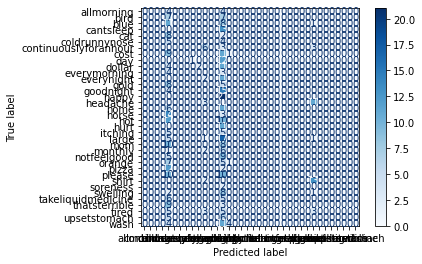

<Figure size 3600x3600 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Normalized, Butterworth to SVM
x = buttermatrix.iloc[:, buttermatrix.columns!='Word'].values   # Features
y = buttermatrix.loc[:,'Word'].values     # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

clf = SVC()
clf.fit(x_train, y_train)
print ('score', clf.score(x_test, y_test))
y_pred=clf.predict(x_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#print(classification_report(y_test, y_pred, target_names=words))
butterresults=classification_report(y_test, y_pred, target_names=words)

['allmorning' 'allmorning' 'allmorning' 'allmorning' 'allmorning'
 'allmorning' 'allmorning' 'allmorning' 'allmorning' 'allmorning'
 'allmorning' 'allmorning' 'allmorning' 'allmorning' 'allmorning'
 'allmorning' 'allmorning' 'allmorning' 'allmorning' 'bird' 'bird' 'bird'
 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird'
 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird'
 'bird' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue' 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep'
 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep'
 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep'
 'cantsleep' 'cantsleep' 'cantsleep' 'cantsleep' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat

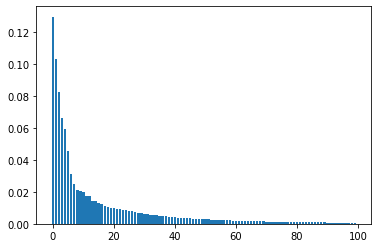

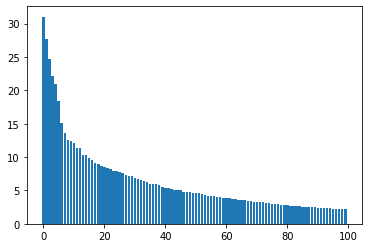

In [12]:
# PCA for norm_matrix

x = norm_matrix_eago.iloc[:, norm_matrix_eago.columns!='Word'].values   # Features
y = norm_matrix_eago.loc[:,'Word'].values     # Target
print(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

pca = PCA(n_components=100)
pca.fit(x_train)
x_t_train = pca.transform(x_train)
x_t_test = pca.transform(x_test)

#### plot
print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[:100],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[:100],pca.singular_values_)
plt.show()

score 0.38235294117647056
pred label ['happy' 'shirt' 'itching' 'happy' 'dollar' 'large' 'happy' 'shirt'
 'goodnight' 'swelling' 'happy' 'mom' 'mom' 'hot' 'large' 'mom'
 'thatsterrible' 'goodnight' 'mom' 'large' 'mom' 'cost' 'goodnight' 'cat'
 'dollar' 'thatsterrible' 'continuouslyforanhour' 'bird' 'goodnight' 'mom'
 'happy' 'dollar' 'dollar' 'mom' 'headache' 'everymorning' 'hot' 'mom'
 'wash' 'itching' 'cat' 'swelling' 'blue' 'goodnight' 'goodnight' 'horse'
 'large' 'happy' 'tired' 'goodnight' 'large' 'goodnight' 'blue' 'itching'
 'everymorning' 'happy' 'swelling' 'mom' 'goodnight' 'dollar' 'everynight'
 'goodnight' 'happy' 'wash' 'mom' 'goodnight' 'monthly' 'coldrunnynose'
 'swelling' 'thatsterrible' 'horse' 'goodnight' 'headache' 'goodnight'
 'hot' 'mom' 'cost' 'swelling' 'day' 'gold' 'goodnight' 'mom' 'mom'
 'swelling' 'blue' 'hot' 'mom' 'blue' 'tired' 'goodnight' 'headache' 'mom'
 'cost' 'horse' 'hot' 'coldrunnynose' 'continuouslyforanhour' 'horse'
 'happy' 'large' 'pizza' 'mom' '

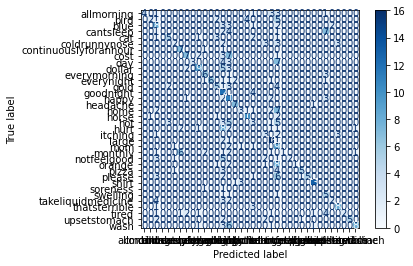

<Figure size 3600x3600 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Normalized, Butterworth, PCA to SVM
clf = SVC()
clf.fit(x_t_train, y_train)
print ('score', clf.score(x_t_test, y_test))
y_pred=clf.predict(x_t_test)
print ('pred label', y_pred)
print('length',len(clf.predict(x_t_test)))

# Confusion matrix
plot_confusion_matrix(clf, x_t_test, y_test,
                                 cmap=plt.cm.Blues)
plt.figure(figsize=(50,50))
plt.show()

#print(classification_report(y_test, y_pred, target_names=words))
pcaresults=classification_report(y_test, y_pred, target_names=words)

**Summary of results**


In [14]:
print('Directly:')
print(directresults)
print('Normalized:')
print(normresults)
print('Butterworth:')
print(butterresults)
print('PCA:')
print(pcaresults)

Directly:
                       precision    recall  f1-score   support

           allmorning       0.00      0.00      0.00        11
                 bird       0.00      0.00      0.00        15
                 blue       0.00      0.00      0.00        19
            cantsleep       0.00      0.00      0.00        12
                  cat       0.00      0.00      0.00        16
        coldrunnynose       0.00      0.00      0.00        12
continuouslyforanhour       0.00      0.00      0.00        14
                 cost       0.00      0.00      0.00        20
                  day       0.00      0.00      0.00        14
               dollar       0.00      0.00      0.00        18
         everymorning       0.00      0.00      0.00        10
           everynight       0.00      0.00      0.00        14
                 gold       0.00      0.00      0.00        15
            goodnight       0.05      0.39      0.09        18
                happy       0.00      0.00  

TODO:

-check what happens when combining diff data sources

-graph components

find correlations

-interpret pca results

-try pca per individual/word

-read dataset papers

correlation component with word

-try straight to svm

-resend email

check what is the data

-merge timeseries word index

see how stable each feature are

standard deviation timeseries

-try without filter

multi-class classifier SVM



https://www.researchgate.net/publication/303707429_Combining_Smartphone_and_Smartwatch_Sensor_Data_in_Activity_Recognition_Approaches_an_Experimental_Evaluation

References

https://stackoverflow.com/questions/56449262/how-to-upload-folders-to-google-colab

https://github.com/datarail/datarail/issues/39

https://dbader.org/blog/python-check-if-file-exists

https://datacarpentry.org/python-socialsci/11-joins/index.html

https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html

https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html

https://stackoverflow.com/questions/32194967/how-to-do-pca-and-svm-for-classification-in-python

https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator

https://scikit-learn.org/stable/modules/cross_validation.html

https://stackoverflow.com/questions/47684606/merge-cells-with-pandas

https://scientificallysound.org/2016/08/18/python-analysing-emg-signals-part-3/

https://stackoverflow.com/questions/58374492/python-valueerror-the-length-of-the-input-vector-x-must-be-greater-than-padle

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/

https://www.datacamp.com/community/tutorials/pandas-multi-index

https://www.geeksforgeeks.org/how-to-get-rows-index-names-in-pandas-dataframe/

https://stackoverflow.com/questions/28140771/select-only-one-index-of-multiindex-dataframe

https://www.educative.io/edpresso/how-to-create-a-confusion-matrix-in-python-using-scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

http://www.datasciencemadesimple.com/standard-deviation-function-python-pandas-row-column/

https://stackoverflow.com/questions/39047915/concat-series-onto-dataframe-with-column-name


In [15]:
"""
### Combine all files
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
wordnum=-1
counter=0

for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)
      
      # Replace counter with evaluated term
      for r in range(0,len(trial)):
        trial.iloc[r,0]=wordnum
        
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
          
          # Create plot for EMG

          # Create plot for accelerometer
          plt.figure()
          alx=plt.axes(projection='3d')
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          alx.set_title('Accelerometer on left arm')

          plt.figure()
          arx=plt.axes(projection='3d')
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          arx.set_title('Accelerometer on right arm')

          # Create plot for gyroscope
          plt.figure()
          glx=plt.axes(projection='3d')
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          glx.set_title('Gyroscope on left arm')

          plt.figure()
          grx=plt.axes(projection='3d')
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          grx.set_title('Gyroscope on right arm')
      else:
          matrix=pd.concat([matrix, trial])

          ###############################################
          # Create plot for accelerometer
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          #plt.show()

          # Create plot for gyroscope
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          ###############################################

  reps[wordnum]=repcount
plt.show()
""" 

"\n### Combine all files\nwords=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']\nlengths=np.zeros(849, dtype=int)\nreps=np.zeros(36,dtype=int)\nwordnum=-1\ncounter=0\n\nfor w in words:\n  repcount=0\n  wordnum+=1\n\n  for i in range (10, 120):\n    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'\n\n    if os.path.exists(path)==True:\n      counter+=1\n      repcount+=1\n      trial=pd.read_csv(path)\n      lengths[counter-1]=len(trial)\n      \n      # Replace counter with evaluated term\n      for r in range(0,len(trial)):\n        trial.iloc[r,0]=wordnum\n        \n      # Combine all trials\n      if path=='/content/2MyoASL

In [16]:
"""
# PCA for normmatrix
pca = PCA(n_components=35)
comp=pca.fit_transform(norm_matrix_eago)
principal=pd.DataFrame(data=comp, columns=['PC 0', 'PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10', 
                                           'PC 11', 'PC 12', 'PC 13', 'PC 14', 'PC 16', 'PC 17', 'PC 18', 'PC 19', 'PC 20', 
                                           'PC 21', 'PC 22', 'PC 23', 'PC 24', 'PC 25', 'PC 26', 'PC 27', 'PC 28', 'PC 29', 
                                           'PC 30', 'PC 31', 'PC 32', 'PC 33', 'PC 34', 'PC35'])
#principal.reset_index(drop=True, inplace=True)
#norm_matrix_eago[['Counter']].reset_index(drop=True, inplace=True)
norm_matrix_eago.reset_index(drop=True, inplace=True)
m.reset_index(drop=True, inplace=True)
#finaldf=pd.join([principal, norm_matrix_eago[['Counter']]], axis=1, ignore_index=True).reset_index()
finaldf=principal.join(m[['Counter']],how='outer')
finaldf=finaldf.drop(columns=['PC 0'])
####finaldf=principal
####print(m['Counter'])
####finaldf['Word']=m['Counter']
#finaldf=pd.concat([principal,norm_matrix_eago[['Counter']]], axis=1, ignore_index=True)

print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn,pca.explained_variance_ratio_)
plt.show()
plt.bar(fn,pca.singular_values_)
plt.show()
print(finaldf)
#print(principal.join(norm_matrix_eago[['Counter']],how='inner'))
"""
"""
# PCA for normalizedmatrix
pca = PCA(n_components=34)
pca.fit(normalized_matrix)
print("Normalized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()

# PCA for standardizedmatrix
pca = PCA(n_components=34)
pca.fit(standardized_matrix)
print("Standardized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()
"""

'\n# PCA for normalizedmatrix\npca = PCA(n_components=34)\npca.fit(normalized_matrix)\nprint("Normalized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n\n# PCA for standardizedmatrix\npca = PCA(n_components=34)\npca.fit(standardized_matrix)\nprint("Standardized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n'